In [49]:
from datetime import datetime
import sys

from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss
import matplotlib.pyplot as plt
import torch
from torch.utils.tensorboard import SummaryWriter
import torchvision
from tqdm import tqdm
import plotly.express as px

from lib.models.mlp import MLP

# 3. Bayesian inference

A plain feedforward network is not able to indicate uncertainty about its outputs. When it is given an input that differs a lot from the inputs it received during training, it produces an output with apparently the exact same amount of confidence as when it receives an input similar to the training data.

This can be addressed by using Bayesian inference on the weights of the neural network. Instead of using determinstic values for the weights, the weights are represented by *probability distributions over possible values*. Formally, Bayesian inference computes the posterior distribution of the model weights given the training data: $P(\mathbf{w}| \mathcal{D})$. A single sample from this distribution contains a value for *all* the network weights of the model.

Working directly with $P(\mathbf{w}| \mathcal{D})$, however, is not feasible for neural networks of any practical size. Instead, [Blundell et al. (2015)](https://arxiv.org/abs/1505.05424) propose to use a *variational approximation*. Variational learning finds the parameters $\theta$ of a distribution on the weights $q(\mathbf{w}|\theta)$ such that the KL-divergence (a kind of *dissimilarity* measure) between $q(\mathbf{w}|\theta)$ and $P(\mathbf{w}| \mathcal{D})$ is minimized. In other words: we tweak the parameters $\theta$ such that $q(\mathbf{w}|\theta)$ looks like $P(\mathbf{w}| \mathcal{D})$. 

This *KL-divergence* can be approximated by the following loss function:

$$
f(\mathbf{w}, \theta) = \sum_{i=1}^n \log q\left(\mathbf{w}^{(i)} \mid \theta\right)-\log P\left(\mathbf{w}^{(i)}\right) -\log P\left(\mathcal{D} \mid \mathbf{w}^{(i)}\right)
$$

where $\mathbf{w}^{(i)}$ is a random sample drawn from $q(\mathbf{w}|\theta)$. Note that the first two terms will be low when $q\left(\mathbf{w} \mid \theta\right)$ is similar to the prior distribution over the weights $P\left(\mathbf{w}\right)$, i.e., these terms **regularize** the model weights. The last term (the *likelihood cost*) will be low when the sampled network parameters $\mathbf{w}^{(i)}$ can correctly predict the output of many input samples in the training dataset $\mathcal{D}$.

We want this loss function to be *differentiable* with respect to $\theta$, such that gradients can be computed and a gradient descent-like optimization algorithm can be used to let $q(\mathbf{w}|\theta)$ be more similar to $P(\mathbf{w}| \mathcal{D})$.

If we assume that $q(\mathbf{w}|\theta)$ is a diagonal Gaussian distribution, then $\theta$ consists of a mean $\mu$ and a standard deviation $\sigma$ (note that each of these is a *vector* of the same length as the number of weights in the network). In that case, a sample $\mathbf{w}^{(i)}$ can be obtained by drawing a random sample $\epsilon^{(i)}$ from a unit Gaussian, shifting it by $\mu$ and scaling it by $\sigma$:

$$
\mathbf w^{(i)} = \mathbf\mu + \sigma\odot \epsilon,
$$

with $\epsilon^{(i)}\sim\mathcal{N}(0, I)$ and $\odot$ an element-wise multiplication. During training, we want to modify $\mu$ and $\sigma$ such that the loss function $f(\mathbf{w}, \theta)$ is minimized. Directly training $\sigma$ might not be a good idea, as $\sigma$ should be strictly positive and we do not have a guarantee that during training $\sigma$ would only get positive values. Instead, we replace it by a [softplus](https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html) function applied to a parameter $\rho\in\mathbb R$:

$$
\mathbf w^{(i)} = \mathbf\mu + \underbrace{\log\left(1 + \exp(\mathbf\rho)\right)}_{= \sigma}\odot \epsilon.
$$

Parameter $\rho$ can get both positive and negative values; $\sigma = \log\left(1 + \exp(\mathbf\rho)\right)$ is guaranteed to be positive.

Now, the neural network can be optimized by repeating the following steps:

1. Sample $\epsilon^{(i)}\sim\mathcal N(0, I)$
2. Let $\mathbf w^{(i)} = \mathbf\mu + \log\left(1 + \exp(\mathbf\rho)\right)\odot \epsilon$
3. Let $\theta = (\mu, \rho)$
4. Let $f(\mathbf w, \theta) = \log q\left(\mathbf{w}^{(i)} \mid \theta\right)-\log P\left(\mathbf{w}^{(i)}\right) P\left(\mathcal{D} \mid \mathbf{w}^{(i)}\right)$
5. Calculate the gradient of $f$ w.r.t. the mean $\mu$
7. Calculate the gradient of $f$ w.r.t. the standard deviation parameter $\rho$
8. Update the parameters of the variational posterior
$$
\begin{aligned}
&\mu \leftarrow \mu-\alpha \Delta_\mu \\
&\rho \leftarrow \rho-\alpha \Delta_\rho .
\end{aligned}
$$


## 3.1 Moving an MLP into the Bayesian world

With the library [BayesianTorch](https://github.com/IntelLabs/bayesian-torch), we can easily turn any MLP into a network that is ready for some Bayesian inference. Below, we show a code snippet of how you can do this.

In [50]:
const_bnn_prior_parameters = {
    "prior_mu": 0.0,  # initialize μ of prior P(w), this will not be trained
    "prior_sigma": 1.0,  # initialize σ of prior P(w), this will not be trained
    "posterior_mu_init": 0.0,  # initialize μ of var. posterior q(w|θ)
    "posterior_rho_init": -3.0,  # initialize ρ of var. posterior q(w|θ), with σ = log(1 + exp(ρ))
    "type": "Reparameterization",  # Use algorithm from Blundell et al. (2015)
    "moped_enable": False,
}


mlp = MLP(
    num_input_neurons=1,
    num_hidden_neurons=[100, 100],  # A two-layer network, each hidden layer has 100 neurons,
    num_output_neurons=1,
    activation='Tanh',
    output_activation=None,
)

dnn_to_bnn(mlp, const_bnn_prior_parameters)

## 3.2 Bayesian training

Thanks to BayesianTorch, training this network feel much like training any other network in PyTorch.

In [51]:
LOG_DIR = 'runs_bayes'  # This is the name of the directory in which we will put the TensorBoard logs

# Create a SummaryWriter instance with a meaningful run name
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')  # We will append a timestamp to make the run name unique
run_name = f'{mlp.num_hidden_neurons}_{timestamp}'
writer = SummaryWriter(log_dir=f'{LOG_DIR}/{run_name}')

Start a new TensorBoard from the OnDemand dashboard with `anndl_es1_files/es1/runs_bayes` as value for the "Project/Log folder". You can kill the TensorBoard of the previous notebook.

In [52]:
# Define dataset
x_a = torch.linspace(-1, 0, 100)[:, None]
x_b = torch.linspace(0, 1, 2)[:, None]
x = torch.cat([x_a, x_b])
y = x**2

# Create an optimizer
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

# Create a loss function
loss_fn = torch.nn.MSELoss()

MAX_EPOCHS = 10000
BATCH_SIZE = len(x)

for epoch in tqdm(range(MAX_EPOCHS)):
    output = mlp(x)
    kl = get_kl_loss(mlp) / BATCH_SIZE  # KL divergence between q(w|θ) and the prior P(w)
    mse_loss = loss_fn(output, y)  # Likelihood cost
    loss = mse_loss + kl
    writer.add_scalar('Loss/Train', loss, epoch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 10000/10000 [00:39<00:00, 252.83it/s]


## 3.3 Bayesian inference

Since our MLP is stochastic now, the same input will yield different outputs. By passing the same input multiple times, we approximate the output distribution for that input (i.e., we perform a Monte Carlo simulation) and as such get an idea of how uncertain the network of the output it predicts for the given input. Below, we pass the same test dataset multiple times through the MLP and collect the outputs.

In [53]:
NUM_MONTE_CARLO = 1000

# Generate 4 different test inputs (-2, -1, 0, 1)
x_test = torch.arange(-2, 2)[:, None]

# For each of the 4 different inputs, get 1000 outputs
with torch.no_grad():
    y_preds = torch.hstack([
        mlp(x_test)
        for _ in tqdm(range(NUM_MONTE_CARLO))
    ])

100%|██████████| 1000/1000 [00:00<00:00, 3557.77it/s]


We can compute the mean and standard deviation of the outputs that corresponded to the same inputs like so:

In [54]:
y_pred_mean = y_preds.mean(dim=1)
y_pred_std = y_preds.std(dim=1)

print(f'mean: {y_pred_mean}, std: {y_pred_std}')

mean: tensor([0.5427, 0.8379, 0.0311, 0.4638]), std: tensor([0.2148, 0.1366, 0.1319, 0.1911])


We can now visualize the mean of the predicted values, along with an error band that indicates the model's uncertainty.

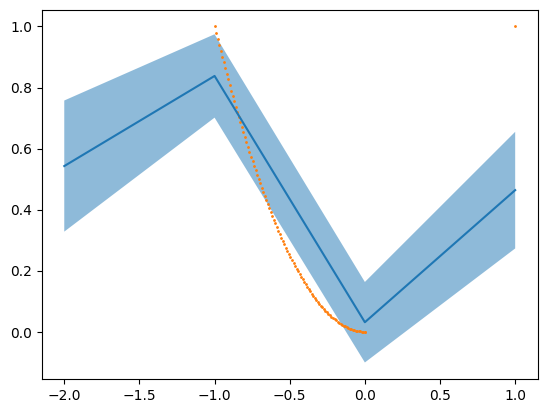

In [55]:
fig, ax = plt.subplots()
ax.plot(x_test, y_pred_mean.flatten())
ax.fill_between(
    x_test.flatten(),
    (y_pred_mean - y_pred_std).flatten(),
    (y_pred_mean + y_pred_std).flatten(),
    alpha=0.5
)

ax.scatter(x, y.flatten(), s=1.0)

## 3.4 Exercise

Train an MLP for Bayesian inference on the clean and noisy dataset you used in the previous exercise (from the function $y = \sin(x^2)$) and compare it with the other training algorithms investigated there. Compare the test errors. Consider overparameterized networks (many neurons): do you see any improvement?

In [56]:
# Generation of the datasets
x = torch.arange(0, 3*torch.pi, 0.05)[:, None]
y = torch.sin(x**2)

# We keep the features (x) the same but add noise to the labels (y)
# Generate the noise scalar for the labels
noise_scalar = torch.randn_like(y)

# Apply the noise scalar to the the labels
y_noisy = torch.mul(y, noise_scalar)

In [57]:
# Plot normal data
x_plot = x.reshape(-1)
y_plot = y.reshape(-1)

fig = px.scatter(x=x_plot.numpy(), y=y_plot.numpy())
fig.show()

In [58]:
# Plot noisy data
x_plot = x.reshape(-1)
y_noisy_plot = y_noisy.reshape(-1)

fig = px.scatter(x=x_plot.numpy(), y=y_noisy_plot.numpy())
fig.show()

In [59]:
# Normal data
# 1. Define your model
const_bnn_prior_parameters = {
    "prior_mu": 0.0,  # initialize μ of prior P(w), this will not be trained
    "prior_sigma": 1.0,  # initialize σ of prior P(w), this will not be trained
    "posterior_mu_init": 0.0,  # initialize μ of var. posterior q(w|θ)
    "posterior_rho_init": -3.0,  # initialize ρ of var. posterior q(w|θ), with σ = log(1 + exp(ρ))
    "type": "Reparameterization",  # Use algorithm from Blundell et al. (2015)
    "moped_enable": False,
}
mlp_normal = MLP(
    num_input_neurons=1,
    num_hidden_neurons=[100, 100],  # A two-layer network, each hidden layer has 100 neurons,
    num_output_neurons=1,
    activation='Tanh',
    output_activation=None,
)
dnn_to_bnn(mlp_normal, const_bnn_prior_parameters)

# 2. Create an optimizer
optimizer = torch.optim.Adam(mlp_normal.parameters(), lr=0.01)

# 3. Create a loss function
loss_fn = torch.nn.MSELoss()

# Create a SummaryWriter instance
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')
run_name = f'not_noisy_{timestamp}'
writer = SummaryWriter(log_dir=f'{LOG_DIR}/{run_name}')

# Train
MAX_EPOCHS = 60000
BATCH_SIZE = len(x)
for epoch in tqdm(range(MAX_EPOCHS)):
    output = mlp_normal(x)
    kl = get_kl_loss(mlp_normal) / BATCH_SIZE  # KL divergence between q(w|θ) and the prior P(w)
    mse_loss = loss_fn(output, y)  # Likelihood cost
    loss = mse_loss + kl
    writer.add_scalar('Loss/Train', mse_loss, epoch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  1%|          | 500/60000 [00:02<03:46, 263.21it/s]

In [ ]:
# Generate 2 different test inputs (pi and 5pi)
x_test = torch.tensor([[0.0],[0.5],[1.5],[torch.pi]])

# For each of the 4 different inputs, get 1000 outputs
with torch.no_grad():
    y_preds = torch.hstack([
        mlp_normal(x_test)
        for _ in tqdm(range(1000))
    ])

# Calculate the distribution of the outputs
y_pred_mean = y_preds.mean(dim=1)
y_pred_std = y_preds.std(dim=1)

print(f'mean: {y_pred_mean}, std: {y_pred_std}')

100%|██████████| 1000/1000 [00:00<00:00, 3856.09it/s]

mean: tensor([ 0.0047,  0.1225,  0.1225, -0.5183]), std: tensor([0.0812, 0.1024, 0.1024, 0.2302])


In [ ]:
# Noisy data
# 1. Define your model
const_bnn_prior_parameters = {
    "prior_mu": 0.0,  # initialize μ of prior P(w), this will not be trained
    "prior_sigma": 1.0,  # initialize σ of prior P(w), this will not be trained
    "posterior_mu_init": 0.0,  # initialize μ of var. posterior q(w|θ)
    "posterior_rho_init": -3.0,  # initialize ρ of var. posterior q(w|θ), with σ = log(1 + exp(ρ))
    "type": "Reparameterization",  # Use algorithm from Blundell et al. (2015)
    "moped_enable": False,
}
mlp_noise = MLP(
    num_input_neurons=1,
    num_hidden_neurons=[100, 100],  # A two-layer network, each hidden layer has 100 neurons,
    num_output_neurons=1,
    activation='Tanh',
    output_activation=None,
)
dnn_to_bnn(mlp_noise, const_bnn_prior_parameters)

# 2. Create an optimizer
optimizer = torch.optim.Adam(mlp_noise.parameters(), lr=0.01)

# 3. Create a loss function
loss_fn = torch.nn.MSELoss()

# Create a SummaryWriter instance
timestamp = datetime.now().strftime('%Y-%M-%dT%H-%M-%S')
run_name = f'noisy_{timestamp}'
writer = SummaryWriter(log_dir=f'{LOG_DIR}/{run_name}')

# Train
MAX_EPOCHS = 60000
BATCH_SIZE = len(x)
for epoch in tqdm(range(MAX_EPOCHS)):
    output = mlp_noise(x)
    kl = get_kl_loss(mlp_noise) / BATCH_SIZE  # KL divergence between q(w|θ) and the prior P(w)
    mse_loss = loss_fn(output, y_noisy)  # Likelihood cost
    loss = mse_loss + kl
    writer.add_scalar('Loss/Train', mse_loss, epoch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 60000/60000 [03:24<00:00, 292.91it/s]


In [ ]:
# Generate 2 different test inputs (pi and 5pi)
x_test = torch.tensor([[0.0],[0.5],[1.5],[torch.pi]])

# For each of the 4 different inputs, get 1000 outputs
with torch.no_grad():
    y_preds = torch.hstack([
        mlp_noise(x_test)
        for _ in tqdm(range(1000))
    ])

# Calculate the distribution of the outputs
y_pred_mean = y_preds.mean(dim=1)
y_pred_std = y_preds.std(dim=1)

print(f'mean: {y_pred_mean}, std: {y_pred_std}')

100%|██████████| 1000/1000 [00:00<00:00, 5557.25it/s]

mean: tensor([-0.0070, -0.0604,  0.3294,  0.5391]), std: tensor([0.0980, 0.0814, 0.0911, 0.0918])


# 4. Report

Based on the previous exercises of section 2.5 and 3.4, write a report of maximum 4 pages (including text + figures) to discuss the main differences, (dis)advantages, speed, overfitting & generalization of different learning schemes. Show your understanding by explaining all concepts, interpreting your obtained results and making connections to the seen theory.